In [26]:
from huggingface_hub import notebook_login
from datasets import load_dataset, Dataset
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import json

notebook_login()

# I - Collecting Data

For this notebook to work you need to download the **DocLayNet** dataset and put it in the `data/raw/DocLayNet` folder.

https://github.com/DS4SD/DocLayNet

In [27]:
from datasets import load_dataset, Dataset
import datasets

data_path='../data/raw/DocLayNet/COCO/'

ds_raw = load_dataset('json', data_files={'train': data_path+'train.json', 'test': data_path+'test.json', 'val': data_path+'val.json'}, field='annotations')
images = load_dataset('json', data_files={'train': data_path+'train.json', 'test': data_path+'test.json', 'val': data_path+'val.json'}, field='images')
categories = load_dataset('json', data_files={'train': data_path+'train.json', 'test': data_path+'test.json', 'val': data_path+'val.json'}, field='categories')

Using custom data configuration default-d94fd148d232b69f
Found cached dataset json (/Users/pmorelr/.cache/huggingface/datasets/json/default-d94fd148d232b69f/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/3 [00:00<?, ?it/s]

Using custom data configuration default-295173b4ef80bca8
Found cached dataset json (/Users/pmorelr/.cache/huggingface/datasets/json/default-295173b4ef80bca8/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/3 [00:00<?, ?it/s]

Using custom data configuration default-9c98ee879bd27b66
Found cached dataset json (/Users/pmorelr/.cache/huggingface/datasets/json/default-9c98ee879bd27b66/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/3 [00:00<?, ?it/s]

In [28]:
print(f"Train dataset size: {len(ds_raw['train'])}, using a total number of {len(images['train'])} images")
print(f"Test dataset size: {len(ds_raw['test'])}, using a total number of {len(images['test'])} images")
print(f"Validation dataset size: {len(ds_raw['val'])}, using a total number of {len(images['val'])} images")

Train dataset size: 941123, using a total number of 69375 images
Test dataset size: 66531, using a total number of 4999 images
Validation dataset size: 99816, using a total number of 6489 images


# II - Structuring Data

DocLayNet's structure is based on a annotation scheme, in which we have a list of <code>ids</code> that represent a specific bounding box inside a document.

However, for our model input, we want to gather the data linked to **one specific document**. Luckily, for each <code>id</code> we also have a way to trace back which image the bounding box corresponds to. For that, we focus on the <code>image_id</code> information.

Let's start by structuring only our test data, so that we can rapidly assess the code.

In [29]:
PART = 'test'

Now, we focus on creating 3 different lists:
- <code>img_ids</code> will contain an index that corresponds to a specific image.
- <code>bboxes</code> will contain sublists with the bounding boxes of a specific image. Each sublist's index is in accordance with <code>img_ids</code>.
- <code>tags</code> will contain sublists with the labels of every bounding box of a specific image. Again, each sublist's index is in accordance with <code>img_ids</code>.


In [38]:
bboxes_raw = [[]]
tags = [[]]
img_ids = []


img_id = ds_raw[PART][0]['image_id']
img_ids.append(img_id)

for i in range(len(ds_raw[PART])):

    if ds_raw[part][i]['image_id'] == img_id:
        bboxes_raw[-1].append(ds_raw[PART][i]['bbox'])
        tags[-1].append(ds_raw[PART][i]['category_id'] -1)
    else:
        bboxes_raw.append([])
        tags.append([])
        img_ids.append(ds_raw[PART][i]['image_id'])

    img_id = ds_raw[PART][i]['image_id']


- <code>image_path</code> will contain the path to a specific image. Again, each index is in accordance with the image in every other list.


In [49]:
image_path = []

j = 0
for i in range(len(img_ids)):

    while img_ids[i] != images[PART][j]['id']:
        j +=1
    
    image_path.append(images[PART][j]['file_name'])

In [46]:
bboxes = []
for i_doc in range(len(bboxes_raw)):
    bboxes.append([])
    for i_box in range(len(bboxes_raw[i_doc])):
        box = bboxes_raw[i_doc][i_box]
        bboxes[-1].append([box[0], box[1], box[2]+box[0], box[3]+box[1]])

For **vision only models** (R-CNN, ViT, YOLO, etc.) these informations are sufficient to fine-tune the model. So, we can create a new dataset based on these lists:

In [50]:
classes = ['Caption', 'Footnote', 'Formula', 'List-Item', 'Page-Footer', 'Page-Header', 'Picture','Section-Header', 'Table', 'Text', 'Title']

my_dict = {'id': img_ids,
           'bboxes': bboxes,
           'tags': tags,
           'image_path': image_path}

features = datasets.Features({'id': datasets.Value(dtype='int64', id=None),
 'bboxes': datasets.Sequence(feature=datasets.Sequence(feature=datasets.Value(dtype='float64', id=None), length=-1, id=None), length=-1, id=None),
 'tags': datasets.Sequence(datasets.ClassLabel(num_classes=11, names=classes, id=None), length=-1, id=None),
 'image_path': datasets.Value(dtype='string', id=None)})

dataset = Dataset.from_dict(my_dict, features=features)

However, when dealing with **multimodal models**, that take into account both image and text, we need to collect the textual information of certain bounding boxes in the documents.

To do so, we access the folder <code>DocLayNet_extra/JSON</code> in which we have a file for each document, that can be accessed using the <code>image_path</code> hash.

First, we create <code>words_bb</code>, a list in which each sublist will containt the text of a bounding box as the first element, and the corresponding bounding box as the second element.

In [51]:
words_bb = []

files_words = ['../data/raw/DocLayNet/JSON/'+image_path[i].strip('.png')+'.json' for i in range(len(image_path))]

for j in range(len(files_words)):
    data = json.load(open(files_words[j], encoding='utf-8'))
    words_bb.append([[data['cells'][i]['text']] + [data['cells'][i]['bbox']] for i in range(len(data['cells']))])
    

Now let's do some exploration:

Let's see the bounding boxes we get when viewing the image inside the <code>JSON</code> folder:

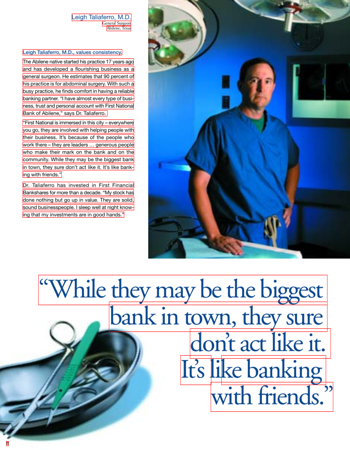

In [52]:
path_imgs='../data/raw/DocLayNet/PNG/'

index = 0

image = Image.open(path_imgs+dataset[index]['image_path'])
image = image.convert("RGB")

bboxes_json = [words_bb[index][i][1] for i in range(len(words_bb[index]))]

draw = ImageDraw.Draw(image)
for b in bboxes_json:
   draw.rectangle([b[0], b[1], b[0]+b[2], b[1]+b[3]], outline='red')

image.resize((350,450))


Now let's do the same for the <code>COCO</code> folder:

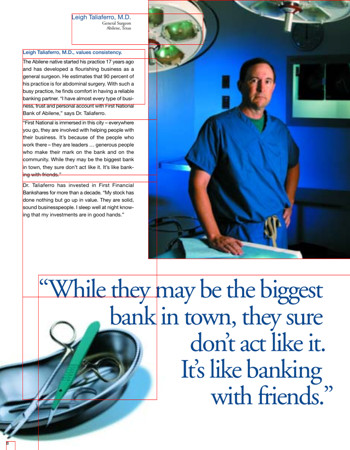

In [53]:
index = 0

image = Image.open(path_imgs+dataset[index]['image_path'])
image = image.convert("RGB")

draw = ImageDraw.Draw(image)
for b in dataset[index]['bboxes']:
   draw.rectangle([b[0], b[1], b[0]+b[2], b[1]+b[3]] ,outline='red')


image.resize((350,450))

There is a clear divergence in here. The bounding boxes and text obtained in the <code>JSON</code> files were most likely a product of an OCR applied to the image. Therefore, we need to check if the `JSON` bounding box is inside the `COCO` bounding box. 

In [54]:
def check_bbox_in(b1, b2):
    if b1[0]<=b2[0] and b1[1]<=b2[1] and b1[0]+b1[2]>=b2[0]+b2[2] and b1[1]+b1[3]>=b2[1]+b2[3]:
        return True

Now we can collect the text and structure this correspondance in the same way that the other lists were structured. For that we create the list `words`. This initial script will concatenate the label with the corresponding text, so that we can check if the code is working apropriately.

In [56]:
img_ids = []
image_path = []
bboxes = []
tags = []
words = []

for i_doc in range(len(dataset)):

    img_ids.append(dataset[i_doc]['id'])
    image_path.append(dataset[i_doc]['image_path'])
    tags.append([])
    bboxes.append([])
    words.append([])

    for i_bb in range(len(dataset[i_doc]['bboxes'])):

        if dataset[i_doc]['tags'][i_bb] in [3,7]:
            tags[-1].append(dataset[i_doc]['tags'][i_bb])
            bboxes[-1].append(dataset[i_doc]['bboxes'][i_bb])
            words[-1].append('')

        else:
            for text in words_bb[i_doc]:
                if check_bbox_in(dataset[i_doc]['bboxes'][i_bb], text[1]) and text[0] not in ['$', '.', '–', '_', '(', ')', '%', '#']:
                   tags[-1].append(dataset[i_doc]['tags'][i_bb])
                   bboxes[-1].append(text[1])
                   words[-1].append(text[0])

In [59]:
classes = ['Caption', 'Footnote', 'Formula', 'List-Item', 'Page-Footer', 'Page-Header', 'Picture','Section-Header', 'Table', 'Text', 'Title']

my_dict = {'id': img_ids,
           'bboxes': bboxes,
           'words': words,
           'tags': tags,
           'image_path': image_path}

dataset = Dataset.from_dict(my_dict)

In [61]:
dataset.to_json('new_test.json')

Creating json from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

104449928